# TP1 ACN 2025 – Simulación AEP
Este notebook usa `aep_sim.py` y sigue el estilo de las clases (NumPy, Monte Carlo, matplotlib).

## Contenidos
1. Parámetros y funciones auxiliares
2. Simulación base (sin eventos de clima)
3. Experimentos para distintos $\lambda\in\{0.02, 0.1, 0.2, 0.5, 1\}$
4. Día ventoso (interrupciones 10%)
5. Cierre sorpresivo de 30 minutos
6. Visualizaciones (timeline de aterrizajes, evolución de distancias)
7. Resumen de métricas con error de estimación


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import aep_sim; reload(aep_sim)
from aep_sim import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()

23.4

### Simulación base
Corramos una simulación con $\lambda=0.1$ para visualizar resultados.

In [7]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
sim = AEPSimulator(cfg)
out = sim.run()
out.landed, out.diverted, out.avg_delay_minutes

(115, 0, 2.7304347826086968)

### Timeline de aterrizajes

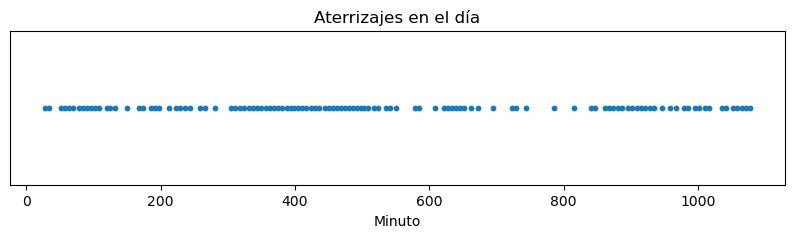

In [8]:
plt.figure(figsize=(10,2))
y = np.zeros(len(out.timeline_landings))
plt.scatter(out.timeline_landings, y, s=10)
plt.yticks([]); plt.xlabel('Minuto'); plt.title('Aterrizajes en el día')
plt.show()

### Experimentos para varios $\lambda$ (promedios y error estándar)

In [9]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=20, seed=123)
res

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -1.0012104926707317,
  'avg_delay_se': 0.05425997800085318,
  'go_around_mean': 4.15,
  'go_around_se': 0.7081294856317258},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 2.2353357903130426,
  'avg_delay_se': 0.269923686699631,
  'go_around_mean': 225.6,
  'go_around_se': 18.937348227635695},
 0.2: {'landed_mean': 167.7,
  'landed_se': 0.47627944031120834,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 8.58389889008795,
  'avg_delay_se': 0.5300631476180053,
  'go_around_mean': 18161.55,
  'go_around_se': 1826.5426723947478},
 0.5: {'landed_mean': 173.9,
  'landed_se': 0.2982404540317303,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 0.7195613112276931,
  'avg_delay_se': 0.0675667741684387,
  'go_around_mean': 200187.7,
  'go_around_se': 

### Día ventoso (10% interrupciones por avión)

In [10]:
res_windy = run_batch(lams, reps=20, seed=123, windy_day=True)
res_windy

{0.02: {'landed_mean': 22.1,
  'landed_se': 1.090388631828603,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.8512645817437161,
  'avg_delay_se': 0.08170943824692864,
  'go_around_mean': 6.15,
  'go_around_se': 0.7155233638467203},
 0.1: {'landed_mean': 103.9,
  'landed_se': 1.36478261234065,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.787840662819472,
  'avg_delay_se': 0.3388450371580886,
  'go_around_mean': 289.75,
  'go_around_se': 21.94800974072472},
 0.2: {'landed_mean': 152.55,
  'landed_se': 0.8567840727793794,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 11.227482803568964,
  'avg_delay_se': 0.4059956682128775,
  'go_around_mean': 26261.5,
  'go_around_se': 1758.5594186570347},
 0.5: {'landed_mean': 155.2,
  'landed_se': 0.5875909783980152,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 5.7603835377046675,
  'avg_delay_se': 0.2016390771732807,
  'go_around_mean': 205943.35,
  'go_around_se': 2

### Cierre sorpresivo de 30 min
Ejemplo: cierre de 12:00 a 12:30 → minutos 360 a 390.

In [11]:
res_closure = run_batch(lams, reps=20, seed=123, closure_window=(360, 390))
res_closure

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.5865469146791484,
  'avg_delay_se': 0.12343137916405145,
  'go_around_mean': 4.9,
  'go_around_se': 0.8822817308726159},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.6488887212584387,
  'avg_delay_se': 0.4494281915768047,
  'go_around_mean': 285.0,
  'go_around_se': 30.466202153931334},
 0.2: {'landed_mean': 162.0,
  'landed_se': 0.6882472016116853,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 9.616825328959173,
  'avg_delay_se': 0.6350320419340368,
  'go_around_mean': 21519.3,
  'go_around_se': 1860.8749372553932},
 0.5: {'landed_mean': 168.6,
  'landed_se': 0.5591346697776559,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 1.9240384221001345,
  'avg_delay_se': 0.12876474535735333,
  'go_around_mean': 203953.8,
  'go_around_se': 

## TODOs sugeridos (para llegar al 100% del enunciado)
- Refinar la lógica de **reinserción** tras go-around: buscar explícitamente el primer hueco ≥10 min y forzar el giro cuando se cumpla y la distancia sea >5 mn.
- Visualización de **trayectorias** (distancia vs. tiempo) para varios aviones en un mismo gráfico, coloreando por estado (approach, go-around, landed, diverted).
- Cálculo de **probabilidad de 5 arribos en una hora** para el caso de $\lambda$ que implica 1 avión/hora (comparar con Poisson/Binomial) y validarlo por simulación.
- Medir **atraso promedio** con distribución completa (boxplots) y su error de estimación (IC 95%).
